In [67]:
import sys
from random import shuffle

import matplotlib.pyplot as plt
import numpy as np
import snntorch
import snntorch.functional as SF
import torch
from matplotlib import cm
from snntorch import surrogate

sys.path.append('../')
from src import data
from src.spiking_neural_network import Snn
from src import pci
from src import plot_params

In [68]:
def get_pci_train(model: Snn,
                  loss,
                  optimizer,
                  train_loader,
                  batch_size: int,
                  frames: list,
                  device: str,
) -> tuple[np.ndarray, np.ndarray, np.ndarray]:
    
    #training_time = len(train_loader)
    training_time = 400
    train_loss = np.zeros(training_time)
    train_acc = np.zeros(training_time)

    num_frames = len(frames)
    num_hidden_layers = model.num_layers - 1
    pci_layers = np.zeros((num_hidden_layers, training_time, num_frames))

    for batch_idx, (train_inputs, train_labels) in enumerate(train_loader):
        train_inputs = train_inputs.to(device)
        train_labels = train_labels.to(device)

        layers = model.forward(train_inputs.view(batch_size, -1))

        train_outputs = layers[-1][0]
        train_loss_batch = loss(train_outputs, train_labels)

        optimizer.zero_grad()
        train_loss_batch.backward()
        optimizer.step()

        train_loss[batch_idx] = train_loss_batch.item()

        train_acc[batch_idx] = SF.accuracy_rate(train_outputs, train_labels)

        # Movie
        checkpoint = {'model_state_dict': model.state_dict()}

        layers = model.movie(checkpoint, frames, device)

        layer_1 = np.zeros((num_frames, 3, model.num_units_layers[1]))
        layer_2 = np.zeros((num_frames, 3, model.num_units_layers[2]))

        for t in range(num_frames):
            layer_1[t,:] = layers[t][0][:]
            layer_2[t,:] = layers[t][1][:]

        spk_1 = layer_1[:,0,:]
        spk_2 = layer_2[:,0,:]

        # PCI
        pci_layers[0,batch_idx,:] = pci.calculate(spk_1.T.astype(int))
        pci_layers[1,batch_idx,:] = pci.calculate(spk_2.T.astype(int))

        print('Training Time:', batch_idx, '/', training_time-1)

        if batch_idx == training_time - 1:
            break
    return train_loss, train_acc, pci_layers

In [69]:
database = 'mnist'
batch_size = 128

train_set, test_set, train_loader, test_loader, device = data.set_loader_device(database, batch_size)

set_name = 'test_set'
imgs_labels = torch.load(
    f'../data/imgs_labels/{database}_{set_name}_imgs_labels.pth')

In [70]:
num_units_layers = [784, 300, 300, 10]
spk_neuron = snntorch.Leaky(
    beta=0.5,
    threshold=1,
    reset_mechanism='subtract',
    spike_grad=surrogate.fast_sigmoid(slope=25))

model = Snn(spk_neuron, num_units_layers).to(device=device)
loss = SF.ce_count_loss()
optimizer = torch.optim.Adam(model.parameters(), lr=5e-4)

In [71]:
def fast_transition_movie(imgs_labels: list, delta_t: int):
    frames = list()
    labels = np.random.randint(10, size=100)
    for l in labels:
        # We randomly choice samples over dataset.
        samples = np.random.randint(800, size=delta_t)
        for t in samples:
            frames +=  [imgs_labels[str(l)][t]]

    return frames 

frames = fast_transition_movie(imgs_labels, delta_t=20)
num_frames = len(frames)
print('num_frames', num_frames)

num_frames 2000


In [31]:
train_loss, train_acc, pci_layers = get_pci_train(model, loss, optimizer, train_loader, batch_size, frames, device)

Training Time: 0 / 199
Training Time: 1 / 199
Training Time: 2 / 199
Training Time: 3 / 199
Training Time: 4 / 199
Training Time: 5 / 199
Training Time: 6 / 199
Training Time: 7 / 199
Training Time: 8 / 199
Training Time: 9 / 199
Training Time: 10 / 199
Training Time: 11 / 199
Training Time: 12 / 199
Training Time: 13 / 199
Training Time: 14 / 199
Training Time: 15 / 199
Training Time: 16 / 199
Training Time: 17 / 199
Training Time: 18 / 199
Training Time: 19 / 199
Training Time: 20 / 199
Training Time: 21 / 199
Training Time: 22 / 199
Training Time: 23 / 199
Training Time: 24 / 199
Training Time: 25 / 199
Training Time: 26 / 199
Training Time: 27 / 199
Training Time: 28 / 199
Training Time: 29 / 199
Training Time: 30 / 199
Training Time: 31 / 199
Training Time: 32 / 199
Training Time: 33 / 199
Training Time: 34 / 199
Training Time: 35 / 199
Training Time: 36 / 199
Training Time: 37 / 199
Training Time: 38 / 199
Training Time: 39 / 199
Training Time: 40 / 199
Training Time: 41 / 199
Tr

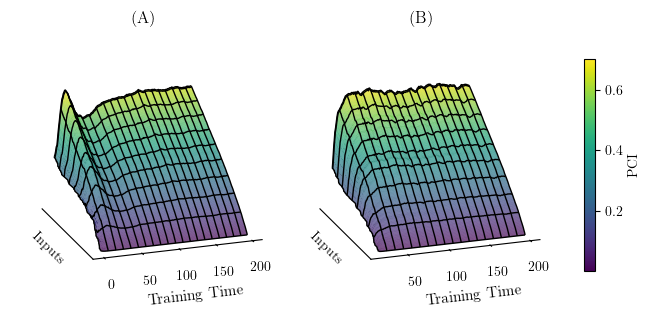

In [73]:
t = np.arange(pci_layers.shape[-1])
a = np.arange(pci_layers.shape[-2])
X, Y = np.meshgrid(t, a)
Z = pci_layers[0, :, :]

fig = plt.figure()
ax = fig.add_subplot(121, projection='3d')

ax.plot_surface(X, Y, Z, cmap=cm.viridis, rstride=1, cstride=1)
ax.plot_wireframe(X, Y, Z, rstride=10, cstride=220, color='black', linewidth=1)

#ax.set_box_aspect(aspect=None, zoom=0.8)

ax.set_xlabel(r'Inputs', fontsize=10, labelpad=-10)
ax.set_xticks([])
#ax.tick_params(axis='x', labelsize=18)
ax.set_ylabel(r'Training Time', fontsize=11)
ax.set_ylim(ax.get_ylim()[::-1])
ax.set_zticks([])
#ax.set_zlabel('PCI', rotation=90)

ax.view_init(elev=15, azim=160, roll=0)

t = np.arange(pci_layers.shape[-1])
a = np.arange(19, pci_layers.shape[-2])
X, Y = np.meshgrid(t, a)
Z = pci_layers[1, 19:, :]

#fig = plt.figure()
ax_1 = fig.add_subplot(122, projection='3d')

plot = ax_1.plot_surface(X, Y, Z, cmap=cm.viridis, rstride=1, cstride=1)
ax_1.plot_wireframe(X, Y, Z, rstride=10, cstride=220, color='black',linewidth=1)

#ax_1.set_box_aspect(aspect=None, zoom=0.8)

ax_1.set_xlabel(r'Inputs', fontsize=10, labelpad=-10)
ax_1.set_xticks([])
#ax_1.tick_params(axis='x', labelsize=18)
ax_1.set_ylabel(r'Training Time', fontsize=11)
# ax_1.set_yticklabels(ax.get_yticks(),)
ax_1.set_ylim(ax_1.get_ylim()[::-1])
ax_1.set_zticks([])
#ax_1.set_zlabel('PCI', rotation=90)
ax.grid(False)

ax.xaxis.set_pane_color((1.0, 1.0, 1.0, 0.0))
ax.yaxis.set_pane_color((1.0, 1.0, 1.0, 0.0))
ax.zaxis.set_pane_color((1.0, 1.0, 1.0, 0.0))
ax.zaxis.set_label_position('none')
ax.zaxis.set_ticks_position('none')

ax_1.xaxis.set_pane_color((1.0, 1.0, 1.0, 0.0))
ax_1.yaxis.set_pane_color((1.0, 1.0, 1.0, 0.0))
ax_1.zaxis.set_pane_color((1.0, 1.0, 1.0, 0.0))

ax_1.zaxis.set_label_position('none')
ax_1.zaxis.set_ticks_position('none')
ax_1.grid(False)
ax_1.view_init(elev=15, azim=160, roll=0)
ax_1.set_facecolor('white')
cbar1 = fig.colorbar(plot, ax=ax_1, pad=0.1, shrink=0.45, label='PCI')

ax_1.set_title('(B)')
ax.set_title('(A)')
ax.tick_params(axis='x', which='major', pad=-10)

# if save == True:
#     fig.savefig(f'../plots/07_pci_anesthesia/pci_frames_alpha_{layer}.png')

# plt.subplots_adjust(wspace=2, hspace=2)

# fig.savefig(f'../plots/pci_anesthesia.pdf')
#fig.savefig(f'../plots/pci_learning.png', dpi=300)
plt.show()